In [1]:
import time
import pooch
import pyproj
import numpy as np
import xarray as xr
import boule as bl
import verde as vd
import matplotlib.pyplot as plt

from boost_and_layouts import (
    EQLHarmonicBoost,
    block_averaged_sources,
    combine_parameters,
)


## Download Australia gravity data

In [2]:
fname = pooch.retrieve(
    url="https://github.com/compgeolab/australia-gravity-data/releases/download/v1.0/australia-ground-gravity.nc",
    known_hash="sha256:50f2fa53c5dc2c66dd3358b8e50024d21074fcc77c96191c549a10a37075bc7e",
    downloader=pooch.HTTPDownloader(progressbar=True),
)

# Load the data with xarray
data = xr.load_dataset(fname)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

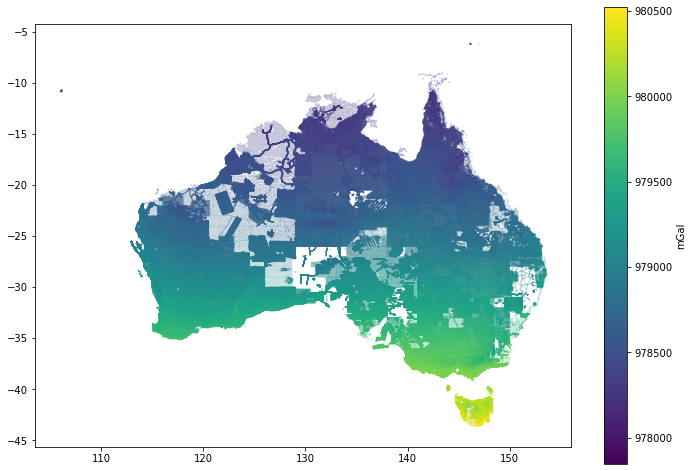

In [4]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Compute gravity disturbance

In [5]:
ell = bl.WGS84
disturbance = data.gravity - ell.normal_gravity(data.latitude, data.height)
data["disturbance"] = ("point", disturbance)

In [6]:
data

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    disturbance        (point) float64 -4.502 -3.588 -3.967 ... 7.314 11.59
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

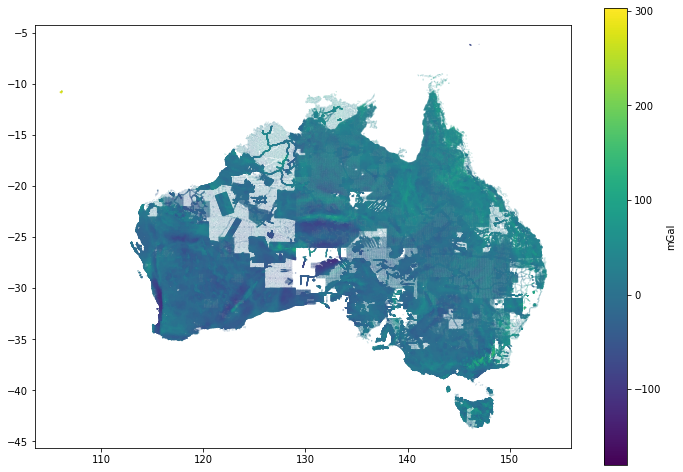

In [7]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Keep only points close to the continent

In [8]:
coordinates = (data.longitude.values, data.latitude.values, data.height.values)
disturbance = data.disturbance.values

vd.get_region(coordinates)

(105.93008499999999, 153.61476, -43.735188, -6.12522)

In [9]:
inside = vd.inside(coordinates, region=(111, 154, -44, -7))
coordinates = tuple(c[inside] for c in coordinates)
disturbance = disturbance[inside]

In [10]:
vd.get_region(coordinates)

(112.934764, 153.61476, -43.735188, -9.008531999999999)

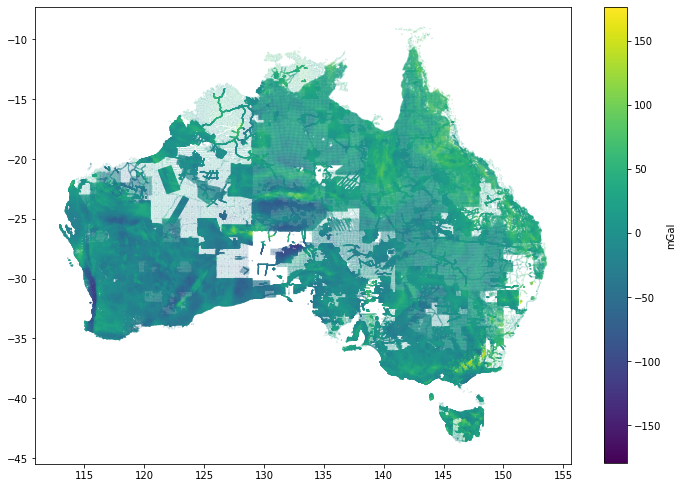

In [11]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

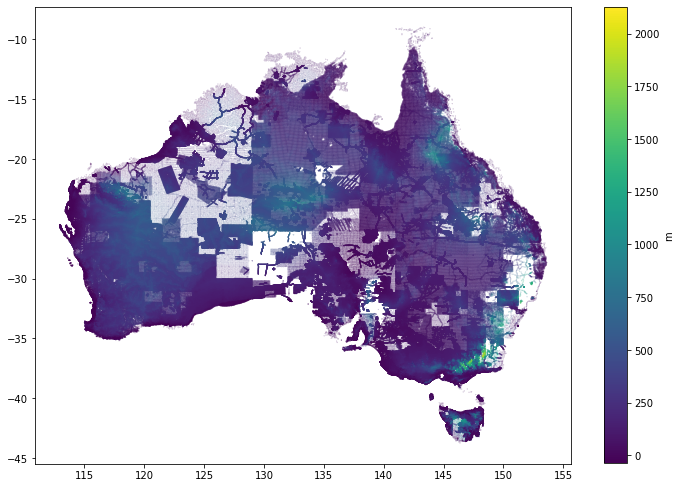

In [12]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*coordinates[:2], c=coordinates[-1], s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="m", shrink=0.7)
plt.show()

## Project coordinates

In [13]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())

easting, northing = projection(*coordinates[:2])
proj_coordinates = (easting, northing, coordinates[-1])

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


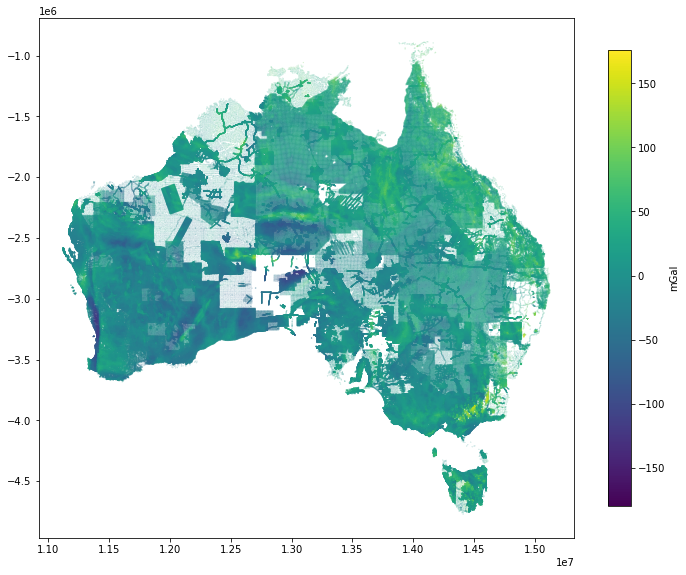

In [14]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*proj_coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.7)
plt.show()

## Estimate window size for gradient boosting

We will choose the spacing for the block-averaged sources equal to the spacing for the ultimate grid.
The final grid will have a spacing of 1 arc-minute, which can be approximated by ~1.8km.

In [15]:
ell.mean_radius * np.radians(1 / 60)

1853.2513289105264

In [16]:
spacing = 1800.0

Estimate the window size for gradient boosting

In [17]:
window_sizes = np.arange(50e3, 350e3, 25e3)

# Create sources with the spacing obtained before
sources = block_averaged_sources(
    proj_coordinates, spacing=spacing, depth_type="relative_depth", depth=0
)

memory_gb = []
for window_size in window_sizes:
    eql = EQLHarmonicBoost(window_size=window_size)
    eql.points_ = sources
    source_windows, data_windows = eql._create_rolling_windows(proj_coordinates)
    # Get the size of each source and data windows
    source_sizes = np.array([w.size for w in source_windows])
    data_sizes = np.array([w.size for w in data_windows])
    # Compute the size of the Jacobian matrix for each window
    jacobian_sizes = source_sizes * data_sizes
    # Register the amount of memory to store the Jacobian matrix (double precision)
    memory_gb.append(jacobian_sizes.max() * (64 / 8) / 1024 ** 3)

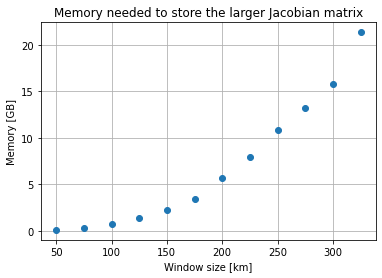

In [18]:
plt.plot(window_sizes * 1e-3, memory_gb, "o")
plt.xlabel("Window size [km]")
plt.ylabel("Memory [GB]")
plt.title("Memory needed to store the larger Jacobian matrix")
plt.grid()
plt.show()

Choose a window size of 250km so we use around of ~10GB of RAM.

In [19]:
window_size = 225e3

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Cross-validate gridder for estimating parameters

Choose only a portion of the data to apply CV to speed up things

In [20]:
easting_0, northing_0 = 14053825.0, -3451038.0
easting_size, northing_size = 300e3, 300e3
smaller_region = (
    easting_0,
    easting_0 + easting_size,
    northing_0,
    northing_0 + northing_size,
)

inside = vd.inside(proj_coordinates, region=smaller_region)
proj_coords_cv = tuple(c[inside] for c in proj_coordinates)
disturbance_cv = disturbance[inside]

print(f"Number of data points for CV: {proj_coords_cv[0].size}")
print(f"Small region: {vd.get_region(proj_coords_cv)}")

Number of data points for CV: 14917
Small region: (14053882.920933582, 14353821.785112651, -3450905.242707166, -3151046.951100357)


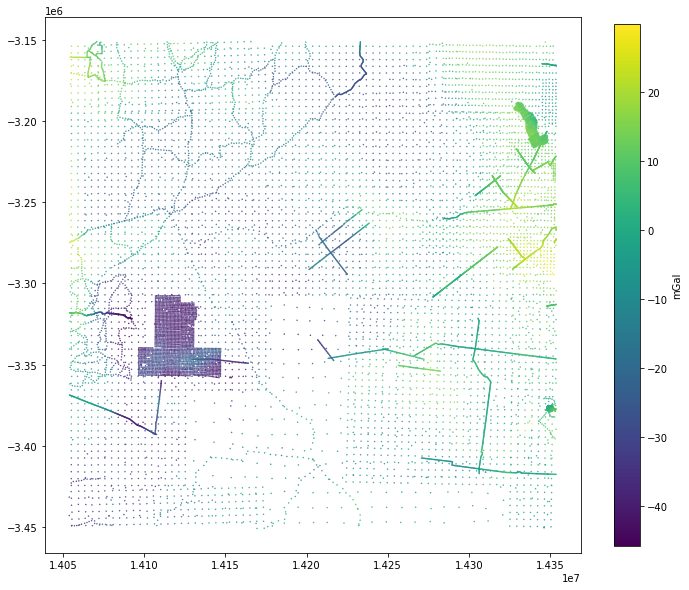

In [21]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*proj_coords_cv[:2], c=disturbance_cv, s=0.2)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal", shrink=0.8)
plt.show()

Define parameters space

In [22]:
depth_type = "relative_depth"
random_state = 0
dampings = np.logspace(-3, 3, 7)
depths = np.linspace(1e3, 10e3, 10)

# Combine these parameters
parameter_sets = combine_parameters(
    **dict(
        depth_type=depth_type,
        depth=depths,
        damping=dampings,
        spacing=spacing,
        window_size=window_size,
        random_state=random_state,
    )
)
print("Number of combinations:", len(parameter_sets))

Number of combinations: 70


Apply cross validation

In [23]:
%%time
cv = vd.BlockKFold(spacing=5e3, n_splits=6, shuffle=True, random_state=0)

scores, scores_std = [], []
for parameters in parameter_sets:
    points = block_averaged_sources(proj_coords_cv, **parameters)
    eql = EQLHarmonicBoost(
        points=points,
        damping=parameters["damping"],
        window_size=parameters["window_size"],
        random_state=parameters["random_state"],
    )
    start = time.time()
    scores_i = vd.cross_val_score(
        eql,
        proj_coords_cv,
        disturbance_cv,
        cv=cv,
    )
    end = time.time()
    score = np.mean(scores_i)
    score_std = np.std(scores_i)
    print(
        "Last CV took: {:.0f}s. Score: {:.3f}. Score std: {:.6f}".format(
            end - start, score, score_std
        )
    )
    scores.append(score)
    scores_std.append(score_std)

Last CV took: 45s. Score: -189.786. Score std: 68.528847
Last CV took: 43s. Score: -35.681. Score std: 6.214846
Last CV took: 43s. Score: -4.458. Score std: 1.372647
Last CV took: 42s. Score: 0.379. Score std: 0.177605
Last CV took: 43s. Score: 0.937. Score std: 0.009151
Last CV took: 42s. Score: 0.986. Score std: 0.004448
Last CV took: 42s. Score: 0.988. Score std: 0.004509
Last CV took: 42s. Score: -31.652. Score std: 9.251870
Last CV took: 42s. Score: -4.073. Score std: 0.601696
Last CV took: 42s. Score: 0.407. Score std: 0.230382
Last CV took: 42s. Score: 0.920. Score std: 0.025968
Last CV took: 42s. Score: 0.984. Score std: 0.003680
Last CV took: 43s. Score: 0.990. Score std: 0.004059
Last CV took: 42s. Score: 0.991. Score std: 0.003858
Last CV took: 43s. Score: -7.004. Score std: 1.530625
Last CV took: 42s. Score: -0.061. Score std: 0.160310
Last CV took: 42s. Score: 0.848. Score std: 0.061260
Last CV took: 42s. Score: 0.966. Score std: 0.007887
Last CV took: 42s. Score: 0.987. S

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


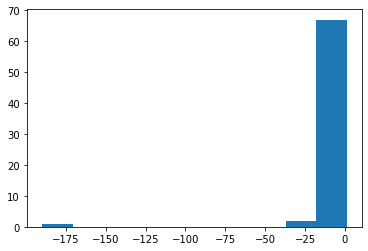

In [24]:
plt.hist(scores)
plt.show()

In [25]:
for score, param in zip(scores, parameter_sets):
    print(score, param)

-189.78638884744873 {'depth_type': 'relative_depth', 'depth': 1000.0, 'damping': 0.001, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}
-35.68089316247748 {'depth_type': 'relative_depth', 'depth': 1000.0, 'damping': 0.01, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}
-4.4580559225636724 {'depth_type': 'relative_depth', 'depth': 1000.0, 'damping': 0.1, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}
0.37877948513169796 {'depth_type': 'relative_depth', 'depth': 1000.0, 'damping': 1.0, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}
0.9366703464979528 {'depth_type': 'relative_depth', 'depth': 1000.0, 'damping': 10.0, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}
0.9855175743241652 {'depth_type': 'relative_depth', 'depth': 1000.0, 'damping': 100.0, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}
0.9882053770148854 {'depth_type': 'relative_depth', 'depth': 1000.0, 'damping': 1000.0, 'spacing': 1800

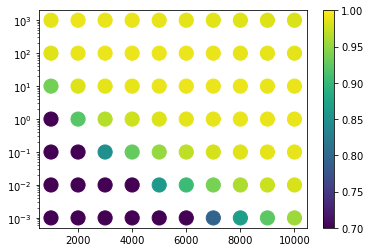

In [26]:
dampings_m, depths_m = np.meshgrid(dampings, depths)
scores_2d = np.array(scores).reshape(depths_m.shape)

plt.scatter(depths_m, dampings_m, c=scores_2d, s=200, vmax=1, vmin=0.7)
plt.yscale("log")
plt.colorbar()
plt.show()

In [27]:
scores_2d

array([[-1.89786389e+02, -3.56808932e+01, -4.45805592e+00,
         3.78779485e-01,  9.36670346e-01,  9.85517574e-01,
         9.88205377e-01],
       [-3.16519606e+01, -4.07343262e+00,  4.06744258e-01,
         9.20420095e-01,  9.83723763e-01,  9.90307322e-01,
         9.90753094e-01],
       [-7.00397961e+00, -6.07970887e-02,  8.48482091e-01,
         9.66263838e-01,  9.87167707e-01,  9.91045487e-01,
         9.90523577e-01],
       [-1.25015527e+00,  6.98935956e-01,  9.29204504e-01,
         9.76848289e-01,  9.89319709e-01,  9.91258274e-01,
         9.89824355e-01],
       [ 3.79088143e-01,  8.61171618e-01,  9.52153558e-01,
         9.83872552e-01,  9.90484237e-01,  9.91110963e-01,
         9.88918660e-01],
       [ 6.95827770e-01,  9.04474429e-01,  9.69588287e-01,
         9.87852817e-01,  9.90897027e-01,  9.90703346e-01,
         9.87910735e-01],
       [ 7.95395962e-01,  9.38356524e-01,  9.80702741e-01,
         9.89389865e-01,  9.90982892e-01,  9.90125499e-01,
         9.8684088

In [28]:
best_score = np.max(scores)
best_parameters = parameter_sets[np.argmax(scores)]

print(best_score)
print(best_parameters)

0.9912582736502923
{'depth_type': 'relative_depth', 'depth': 4000.0, 'damping': 100.0, 'spacing': 1800.0, 'window_size': 225000.0, 'random_state': 0}


## Use the subset for gridding on this subregion

In [29]:
points = block_averaged_sources(proj_coords_cv, **best_parameters)

In [30]:
%%time
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=best_parameters["window_size"],
    random_state=best_parameters["random_state"],
)
eql.fit(proj_coords_cv, disturbance_cv)

CPU times: user 32.1 s, sys: 23.4 s, total: 55.5 s
Wall time: 8.3 s


EQLHarmonicBoost(damping=100.0,
                 points=(array([14055293.99068161, 14057066.1966169 , 14068153.41231569, ...,
       14277853.02710835, 14283606.78904491, 14347050.87542512]),
                         array([-3449280.9424669 , -3449187.12589319, -3449161.71006673, ...,
       -3152733.1942533 , -3152069.36856979, -3151363.91303749]),
                         array([-3930.306, -3929.677, -3917.349, ..., -3886.496, -3883.82 ,
       -3731.779], dtype=float32)),
                 random_state=0, window_size=225000.0)

In [31]:
%%time
# Interpolate on a regular grid
grid = eql.grid(
    upward=data.height.values.max(),
    spacing=spacing,
    data_names=["disturbance"],
)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 752 ms


/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


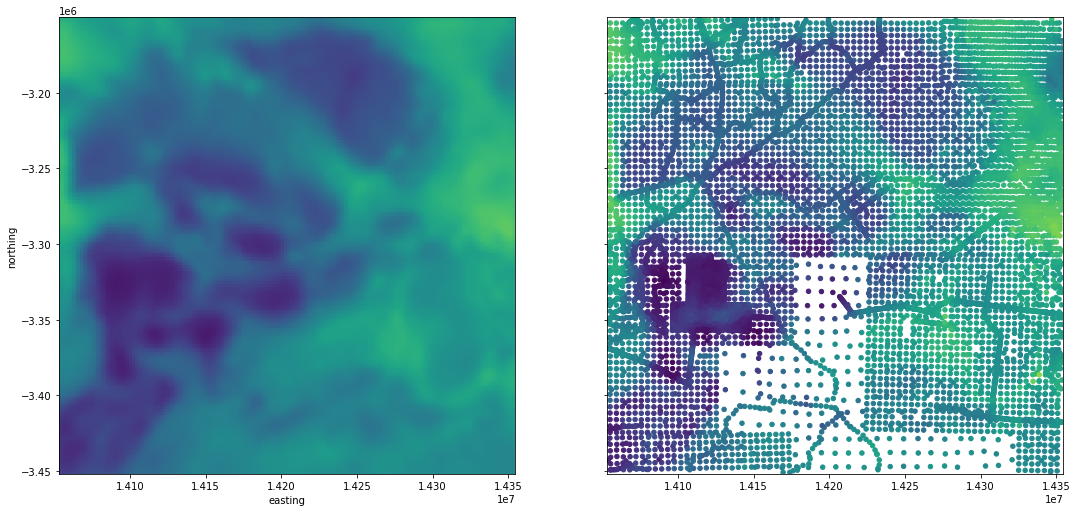

In [32]:
maxabs = vd.maxabs(grid.disturbance, disturbance_cv)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 12), sharex=True, sharey=True)
grid.disturbance.plot(ax=ax1, add_colorbar=False, vmin=-maxabs, vmax=maxabs)

easting, northing = np.meshgrid(grid.easting, grid.northing)
#ax1.scatter(easting, northing, c="k", s=0.05)
#ax1.scatter(*points[:2], c="k", s=0.05)

tmp = ax2.scatter(*proj_coords_cv[:2], c=disturbance_cv, s=20, vmin=-maxabs, vmax=maxabs)
for ax in (ax1, ax2):
    ax.set_aspect("equal")
plt.show()

## Grid gravity disturbance

In [33]:
points = block_averaged_sources(proj_coordinates, **best_parameters)

In [34]:
memory_gb = proj_coordinates[0].size * points[0].size * (64 / 8) / 1024 ** 3

print("Number of data points:", proj_coordinates[0].size)
print("Number of sources:", points[0].size)
print("Memory needed to store the full Jacobian matrix: {:.2f} GB".format(memory_gb))

Number of data points: 1789755
Number of sources: 796744
Memory needed to store the full Jacobian matrix: 10624.35 GB


In [35]:
%%time
eql = EQLHarmonicBoost(
    points=points,
    damping=best_parameters["damping"],
    window_size=best_parameters["window_size"],
    random_state=best_parameters["random_state"],
)
eql.fit(proj_coordinates, disturbance)

CPU times: user 11h 7min 31s, sys: 1h 37min 32s, total: 12h 45min 3s
Wall time: 1h 21min 32s


EQLHarmonicBoost(damping=100.0,
                 points=(array([14411127.63932425, 14401839.90184096, 14412243.24296051, ...,
       14090948.01733475, 14120484.48755517, 14113756.99691306]),
                         array([-4771579.81016954, -4759639.12418224, -4758554.51837204, ...,
        -890979.05122524,  -886852.78427801,  -884706.64306358]),
                         array([-4002.224, -3834.246, -3940.713, ..., -3919.176, -3920.13 ,
       -3919.548], dtype=float32)),
                 random_state=0, window_size=225000.0)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


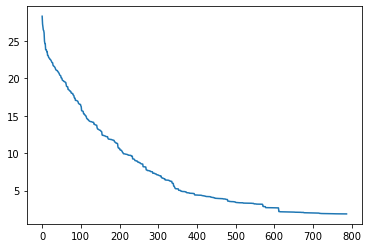

In [36]:
plt.plot(eql.errors_)
plt.show()

In [37]:
%%time
# Get region of longitude, latitude coordinates (in degrees)
region = vd.get_region(coordinates)
# Interpolate on a regular grid on geographic coordinates
grid = eql.grid(
    upward=data.height.values.max(),
    region=region,
    spacing=1/60,
    projection=projection,
    dims=("latitude", "longitude"),
    data_names=["disturbance"],
)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 4h 50min 51s, sys: 0 ns, total: 4h 50min 51s
Wall time: 18min 18s


In [38]:
grid

<xarray.Dataset>
Dimensions:      (latitude: 2085, longitude: 2442)
Coordinates:
  * longitude    (longitude) float64 112.9 113.0 113.0 ... 153.6 153.6 153.6
  * latitude     (latitude) float64 -43.74 -43.72 -43.7 ... -9.042 -9.025 -9.009
    upward       (latitude, longitude) float64 2.128e+03 2.128e+03 ... 2.128e+03
Data variables:
    disturbance  (latitude, longitude) float64 0.1411 0.1403 ... 12.39 12.38
Attributes:
    metadata:  Generated by EQLHarmonicBoost(damping=100.0,\n                ...

In [39]:
grid_masked = vd.distance_mask(
    coordinates, maxdist=80e3, grid=grid, projection=projection
)

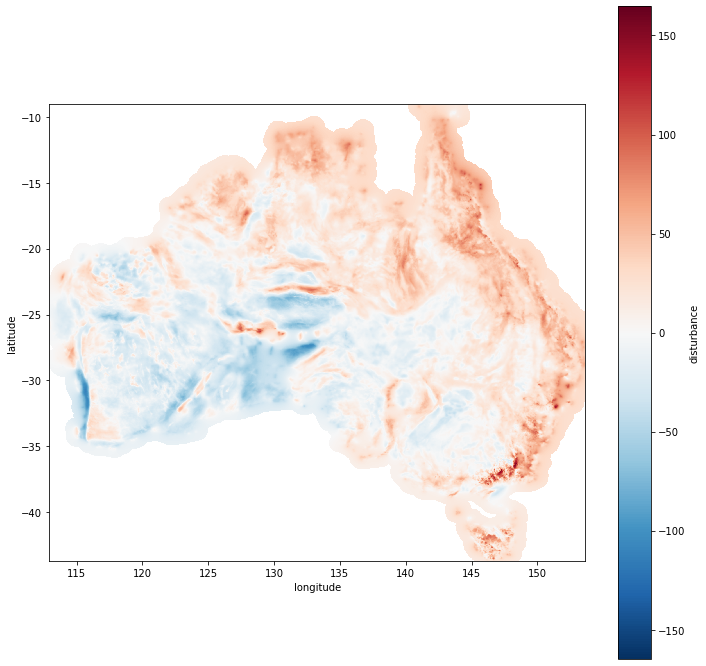

In [40]:
plt.figure(figsize=(12, 12))
grid_masked.disturbance.plot()
plt.gca().set_aspect("equal")
plt.show()

In [41]:
region = (128, 135, -35, -25)

subgrid = grid_masked.sel(longitude=slice(*region[:2]), latitude=slice(*region[2:]))

inside = vd.inside(coordinates, region)
scatter = [c[inside] for c in coordinates]
disturbance_portion = disturbance[inside]

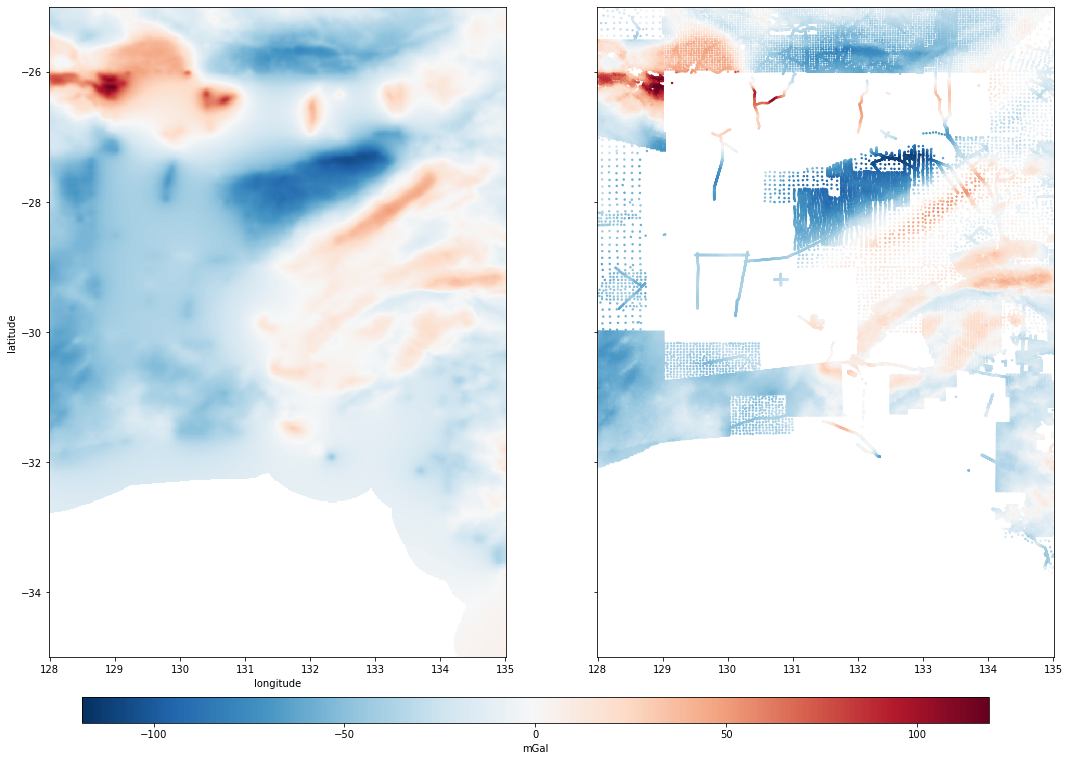

In [42]:
maxabs = vd.maxabs(subgrid.disturbance.values)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 12), sharey=True, sharex=True)
subgrid.disturbance.plot(ax=ax1, add_colorbar=False)
ax1.set_aspect("equal")

tmp = ax2.scatter(*scatter[:2], c=disturbance_portion, s=2, vmin=-maxabs, vmax=maxabs, cmap="RdBu_r")
ax2.set_aspect("equal")

cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
fig.colorbar(tmp, cax=cbar_ax, orientation="horizontal", label="mGal")

plt.show()